In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score , precision_score, recall_score

In [2]:
#check the gpu is available for training
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_dir = "E:/Nigga/ricediseasedetection/rice_datatset/Rice_Leaf_AUG"

In [4]:
image_size = 384
batch_size = 16
channel = 3
n_classes = 9

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 11790 files belonging to 9 classes.


In [6]:
class_names = dataset.class_names
class_names

['Bacterial Leaf Blight',
 'Brown Spot',
 'Healthy Rice Leaf',
 'Leaf Blast',
 'Leaf scald',
 'Narrow Brown Leaf Spot',
 'Neck_Blast',
 'Rice Hispa',
 'Sheath Blight']

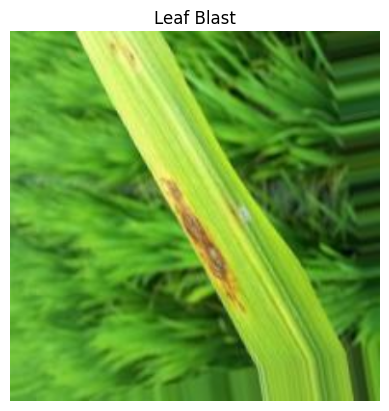

In [7]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [8]:
def split_dataset(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=123)
    train_size = int(train_split*dataset_size)
    val_size = int(val_split*dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset , val_dataset , test_dataset = split_dataset(dataset=dataset)

In [10]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
len(train_dataset)

589

In [12]:
len(test_dataset)

75

In [13]:
len(val_dataset)

73

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])

In [15]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size,image_size),
    layers.Rescaling(1.0/255)
])

In [17]:
model = models.Sequential([
    resize_and_rescale,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(image_size,image_size,channel), padding="valid"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding="valid"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding="valid"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64, (3, 3), activation='relu', padding="valid"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),

])

In [18]:
model.build(input_shape=(None,image_size,image_size,channel))

In [19]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 384, 384, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 382, 382, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 382, 382, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 191, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 189, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 189, 189, 64)    

In [20]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
)
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [21]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/50
 69/589 [==>...........................] - ETA: 3:57 - loss: 2.2581 - accuracy: 0.2083

KeyboardInterrupt: 

In [22]:
scores = model.evaluate(test_dataset)
print("Test Accuracy:", scores[1])

75/75 [==============================] - 336s 78ms/step - loss: 0.4206 - accuracy: 0.8542
Test Accuracy: 0.8541666865348816


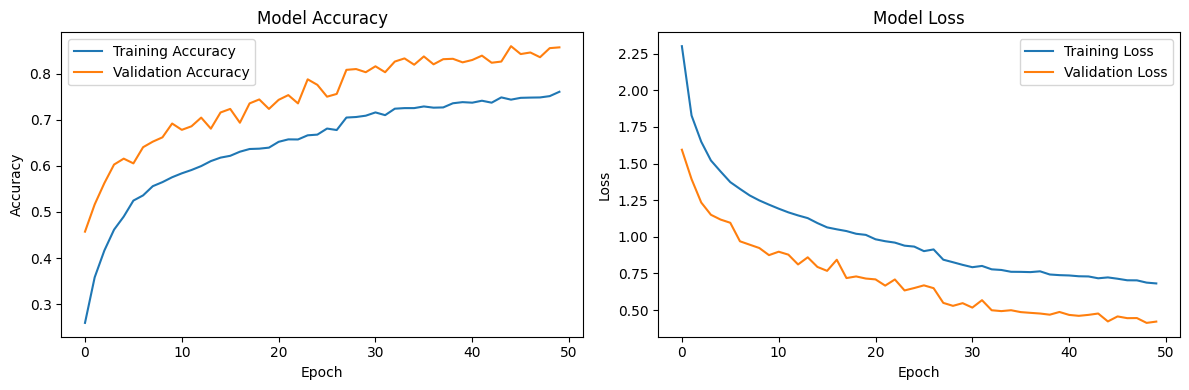

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 58ms/step


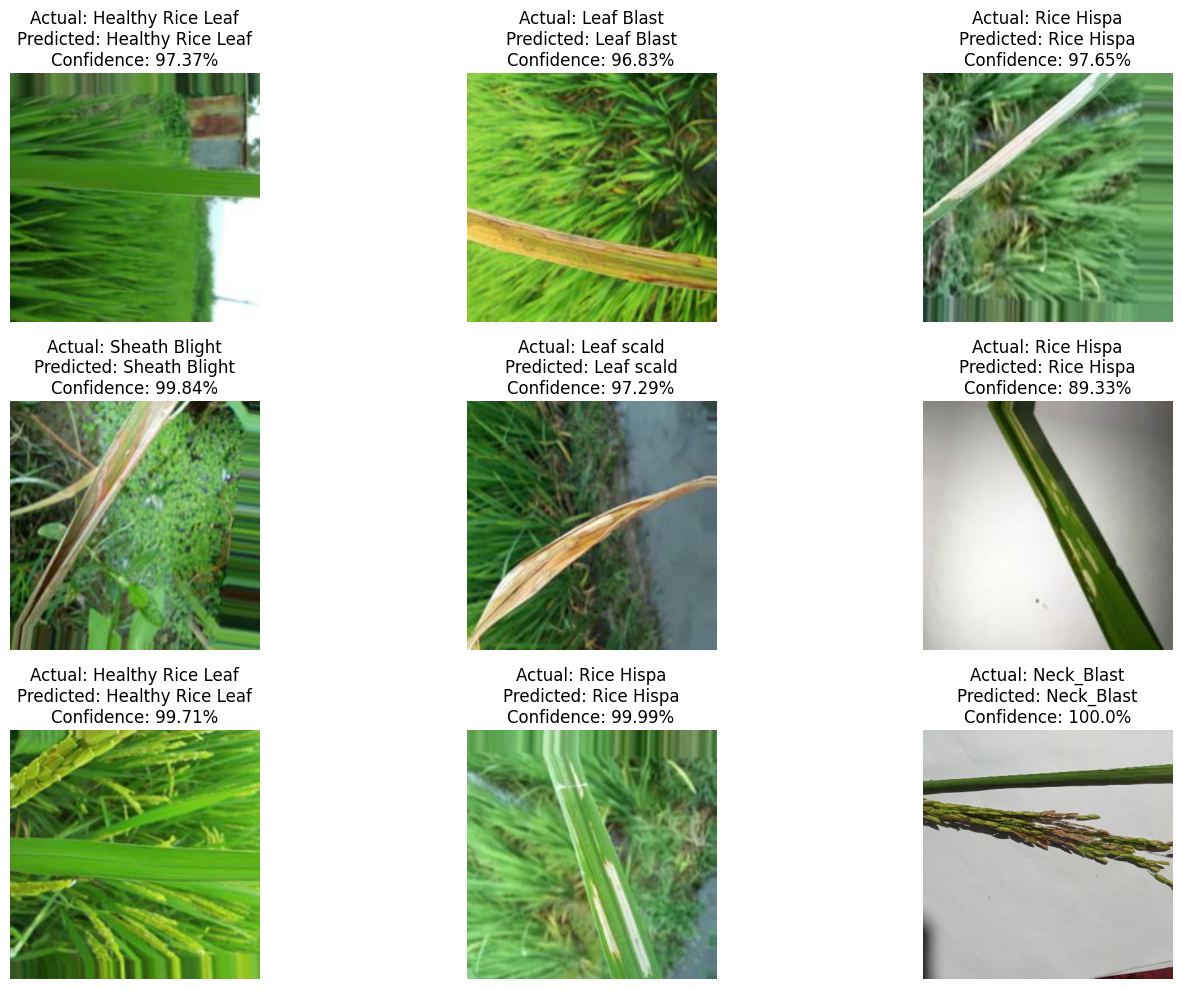

In [25]:
plt.figure(figsize=(15, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.tight_layout()

1/1 [==============================] - 0s 29ms/step


<Figure size 1000x800 with 0 Axes>

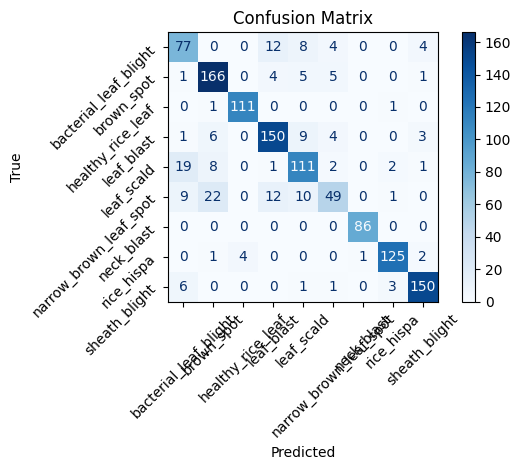

In [26]:

y_true = []
y_pred = []

# Collect predictions
for x, y in test_dataset:
    y_pred.extend(np.argmax(model.predict(x), axis=1))
    y_true.extend(y)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# Define class labels
display_labels = [
    'bacterial_leaf_blight',
    'brown_spot',
    'healthy_rice_leaf',
    'leaf_blast',
    'leaf_scald',
    'narrow_brown_leaf_spot',
    'neck_blast',
    'rice_hispa',
    'sheath_blight'
]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
# Calculate F1 scores for each class
f1_scores = f1_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# Print F1 scores
print("F1 Scores:")
print("bacterial_leaf_blight:", f1_scores[0])
print("brown_spot:", f1_scores[1])
print("healthy_rice_leaf:", f1_scores[2])
print("leaf_blast:", f1_scores[3])
print("leaf_scald:", f1_scores[4])
print("narrow_brown_leaf_spot:", f1_scores[5])
print("neck_blast:", f1_scores[6])
print("rice_hispa:", f1_scores[7])
print("sheath_blight:", f1_scores[8])

# Calculate macro-averaged F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro-averaged F1 Score:", macro_f1)


F1 Scores:
bacterial_leaf_blight: 0.7064220183486237
brown_spot: 0.8601036269430051
healthy_rice_leaf: 0.9736842105263158
leaf_blast: 0.8522727272727273
leaf_scald: 0.7708333333333333
narrow_brown_leaf_spot: 0.5833333333333334
neck_blast: 0.9942196531791908
rice_hispa: 0.9433962264150944
sheath_blight: 0.9316770186335404
Macro-averaged F1 Score: 0.8462157942205738


In [28]:
# Calculate precision and recall
precision = precision_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

recall = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# Print Precision
print("Precision:")
print("bacterial_leaf_blight:", precision[0])
print("brown_spot:", precision[1])
print("healthy_rice_leaf:", precision[2])
print("leaf_blast:", precision[3])
print("leaf_scald:", precision[4])
print("narrow_brown_leaf_spot:", precision[5])
print("neck_blast:", precision[6])
print("rice_hispa:", precision[7])
print("sheath_blight:", precision[8])

# Print Recall
print("\nRecall:")
print("bacterial_leaf_blight:", recall[0])
print("brown_spot:", recall[1])
print("healthy_rice_leaf:", recall[2])
print("leaf_blast:", recall[3])
print("leaf_scald:", recall[4])
print("narrow_brown_leaf_spot:", recall[5])
print("neck_blast:", recall[6])
print("rice_hispa:", recall[7])
print("sheath_blight:", recall[8])


Precision:
bacterial_leaf_blight: 0.6814159292035398
brown_spot: 0.8137254901960784
healthy_rice_leaf: 0.9652173913043478
leaf_blast: 0.8379888268156425
leaf_scald: 0.7708333333333334
narrow_brown_leaf_spot: 0.7538461538461538
neck_blast: 0.9885057471264368
rice_hispa: 0.946969696969697
sheath_blight: 0.9316770186335404

Recall:
bacterial_leaf_blight: 0.7333333333333333
brown_spot: 0.9120879120879121
healthy_rice_leaf: 0.9823008849557522
leaf_blast: 0.8670520231213873
leaf_scald: 0.7708333333333334
narrow_brown_leaf_spot: 0.47572815533980584
neck_blast: 1.0
rice_hispa: 0.9398496240601504
sheath_blight: 0.9316770186335404


In [29]:
model.save('ricedisease_customCNN.h5')

In [30]:
model.save('ricedisease_customCNN.keras')